In [1]:
import os
import sys
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import hashlib
import joblib

from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.stats import randint
from scipy.stats import geom, expon, reciprocal

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

mpl.rc("axes", labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick", labelsize = 12)

### Read the CSV file using Pandas

In [2]:
PATH = "/home/rohan/practice/Machine_Learning/datasets/housing"

In [3]:
def load_housing_data(housing_path = PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


---
Info gives a quick description of the data, in particular, the total number of rows, attribute type and number of non-null values.<br><br>

We can see that there are 20640 instances in the dataset, but total_bedrooms only has 20433 values. That means there are 207 districts missing.<br><br>

We can also see that the ocean_proximity has a different attribute(since we loaded a CSV file, it must be a text attribute). <br><br>

---

Thus, we can check the individual categories from ocean_proximity

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


---
The describe method shows a summary of the numerical attributes. <br><br>

std shows the standard deviation and 25%, 50 and 75% show the percentile 

---

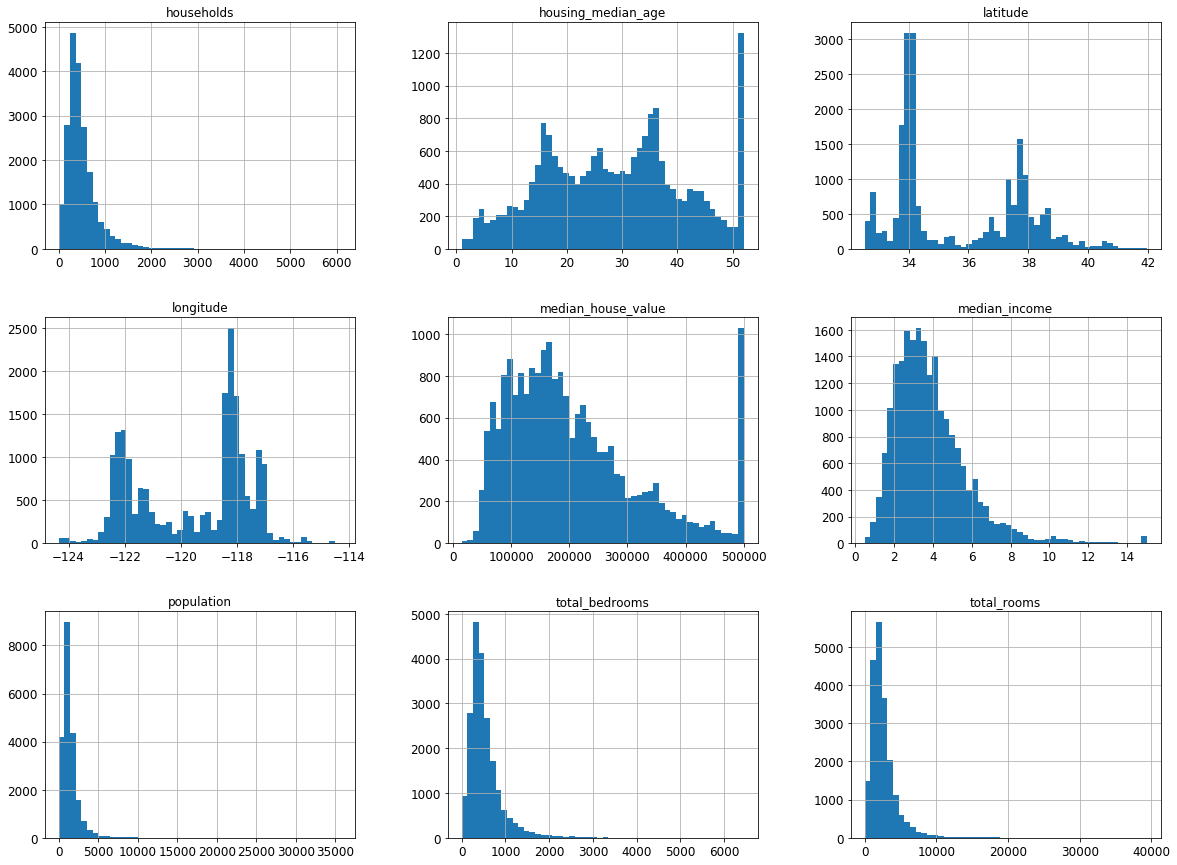

In [8]:
housing.hist(bins = 50, figsize = (20, 15))
#save_fig("attribute _histogram_plots")
plt.show()

---
<b> The histogram can tell us few things about the data.</b>

The median income attribute roughly represents tens of thousands of dollars.
But it is scaled and capped. <br><br>

The housing median age and housing value is also capped. <br><br>

The attributes have very different scales.<br><br>

Many histograms are tail-heavy. We have to reshape them into a more bell-shaped distribution. 

---

Split the dataset into train and test set

In [9]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [10]:
print(len(train_set), len(test_set))
test_set.head()

16512 4128


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


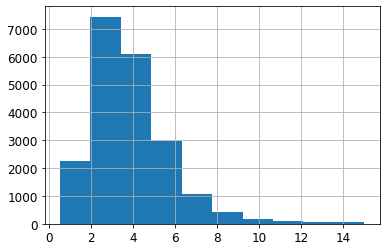

In [11]:
housing["median_income"].hist()

- Suppose Median Income is a very important attribute to predict median housing prices.
- Since median income is a continuous numerical attribute, we need to first create an income category attribute
- From the previous histogram, we can see that most median values are clustered around 1.5-6 (15000-60000), but some values go beyond 6.
- Hence it is important to have a sufficient number instances for each stratum in the dataset, else it might be biased.<br><br>

- Hence, we can create an income category attribute with 5 categories.

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3., 4.5, 6., np.inf], 
                               labels = [1, 2, 3, 4, 5])

In [13]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [14]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


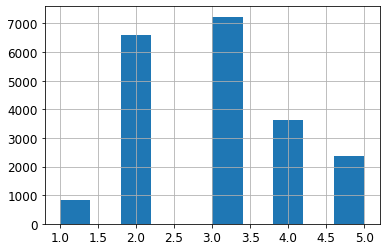

In [15]:
housing["income_cat"].hist();

- Now that we have discrete splits, we can perform a stratified shuffle to better represent the data and reduce bias.

In [16]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [18]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

- Thus we see that the data has been split according to proportion

In [19]:
for set_ in strat_train_set, strat_test_set:
    set_.drop("income_cat", axis = 1, inplace = True)

In [20]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [21]:
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND


---
<h2>EXPLORATORY DATA ANALYSIS<h2>

---

- It is recommended to make a copy of the original dataset before performing EDA, as a backup

In [22]:
housing = strat_train_set.copy()

- Since there's geographical data available, we can create a scatterplot of all the districts

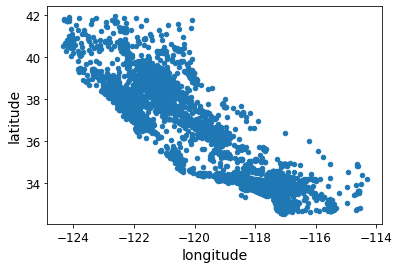

In [23]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")
#save_fig("bad_visualization_plot")

- We can't reall make out too much from the plot.
- We can try changing the density parameter to see the concentration of the plots

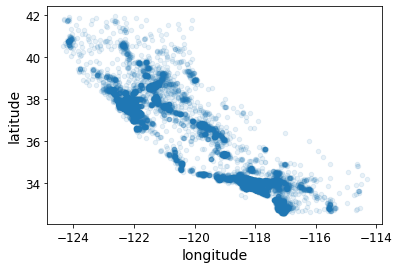

In [24]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)
# save_fig("better_visualization_plot")

- Now we can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno
---
- next, we can take a look at the housing prices

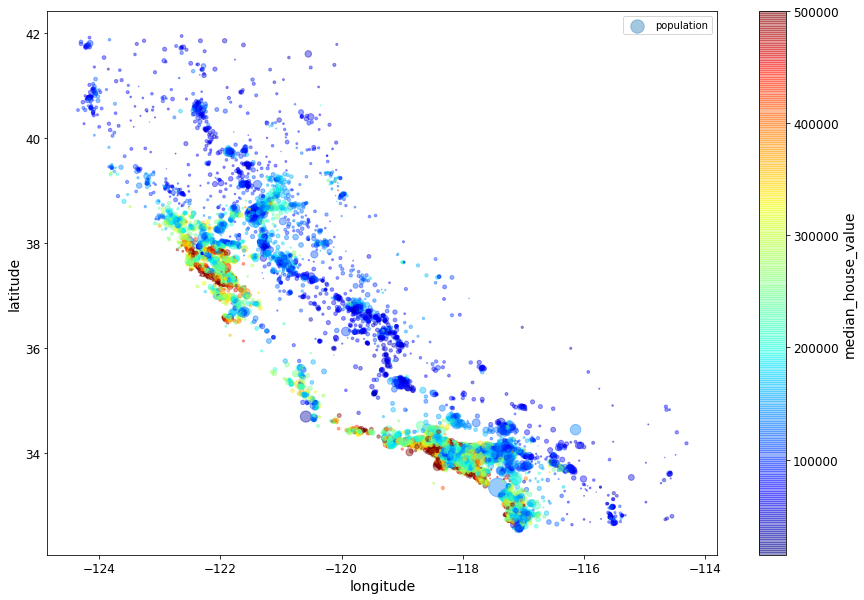

In [25]:
# "s" represents the population density
# "c" represents the price

housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, s = housing["population"] / 100,
            label = "population", figsize = (15, 10), c = "median_house_value", cmap = plt.get_cmap("jet"),
            colorbar = True, sharex = False)
plt.legend();
#savefig("housing_prices_scatterplot");

housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, s = housing["ocean_proximity"],
             label = "Ocean Proximity", figsize = (15, 10), c = "median_house_value", cmap = plt.get_cmap("jet"),
             colorbar = True, sharex = False);

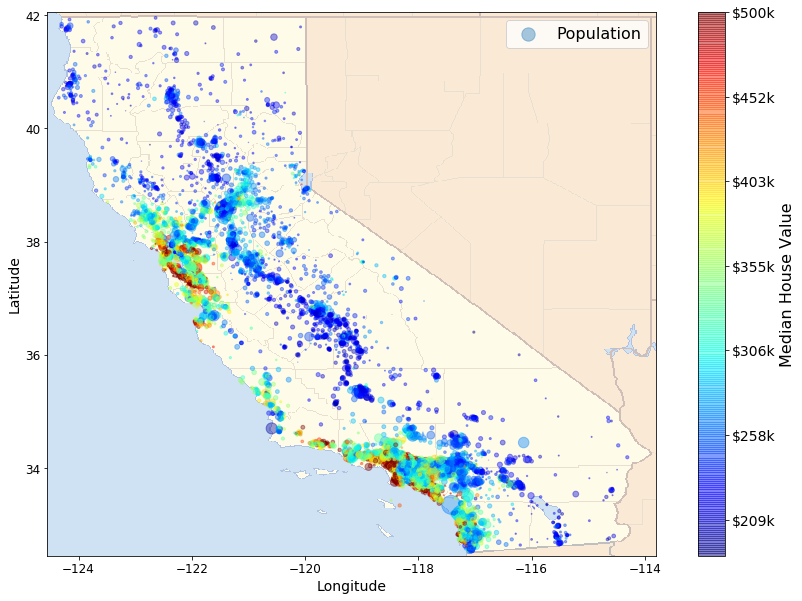

In [26]:
image_path = os.path.join(os.getcwd(), "end_to_end_project", "california.png")

california_img = mpimg.imread(image_path)
ax = housing.plot(kind = "scatter", x = "longitude", y = "latitude", figsize = (15, 10), s = housing['population'] / 100, 
                  label = "Population", c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = False, 
                  alpha = 0.4)
plt.imshow(california_img, extent = [-124.55, -113.80, 32.45, 42.05], alpha = 0.5, cmap = plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize = 14)
plt.xlabel("Longitude", fontsize = 14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v / 1000)) for v in tick_values], fontsize = 14)
cbar.set_label('Median House Value', fontsize = 16)

plt.legend(fontsize = 16)
#save_fig("california_housing_prices_plot")
plt.show()

- Thus, we can make out that the properites closer to the ocean tend to be on the expensive side as compared to the in-land properties.
- But the population density is higher in the inland parts.
---
- Next, we can plot the correlation matrix to see how the attricutes correlates to each other.
- More importantly, we can plot how each attribute correlates to the median house value

In [27]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

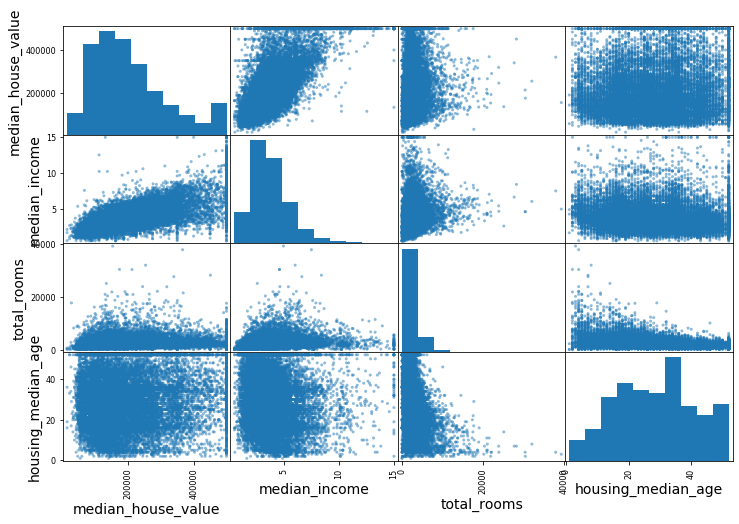

In [28]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12, 8));
#savefig("scatter_matrix_plot");

---
- The correlation coefficient ranges from -1 to 1.
- When the correlation is close to 1, there's strong positive correlation (as seen between median house value and median income).
- When the correlation is close to -1, there's strong negative correlation (as seen between latitude and median house value).
- When the correlation is 0, there's no linear correlation between the attributes.
- On the diagonal, the attributes are plotted against each other, and won't give any information, so instead a histogram is shown in these cells.


![alt text](utils/correlation_plot.png "Correlation Plot")

source: Wikipedia

<br><br>
* It is important to note that this correlation is purely linear in nature, i.e. some non-linear correlations might get missed out on
---
<br>
- The most promising attribute to predict the median housing prices seems to be the median income, so we can take a closer look at it.

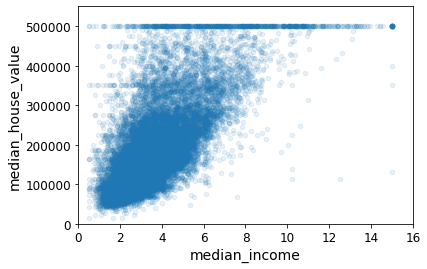

In [29]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)
plt.axis([0, 16, 0, 5.5e5]);
#savefig(income_vs_house_value_scatterplot);

- We can make out that the correlation is indeed strong; there's an upward trend and the points are not too dispersed.
- The price cap at the 500000 mark is clearly visible.
- But we can also observe straight lines at 460000, 350000 and 280000, and a few below that.
- We might need to remove these data districts to prevent our algorithm from making any unnecessary generalizations.

<h2>Experimenting with Attribute Combinations<h2>

- We can see from the correlation plot that most of the features have tail-heavy distribution. 
- We have to make sure that these features are evenlt distributed (by computing their logarithm)
<br><br>
- We can also try out various attribute combinations.
- For example, the total number of bedrooms might not be a useful feature if the number of households are unknown.
- Similarly, the number of bedrooms by itself isn't very useful unless we compare it with the total number of rooms.

In [30]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = True)

bedrooms_per_room          -0.259984
latitude                   -0.142724
longitude                  -0.047432
population                 -0.026920
population_per_household   -0.021985
total_bedrooms              0.047689
households                  0.064506
housing_median_age          0.114110
total_rooms                 0.135097
rooms_per_household         0.146285
median_income               0.687160
median_house_value          1.000000
Name: median_house_value, dtype: float64

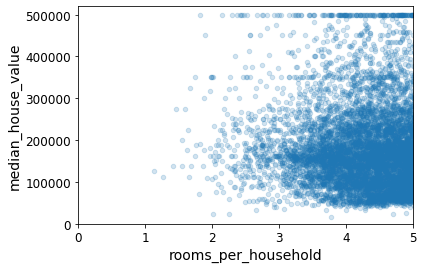

In [32]:
housing.plot(kind = "scatter", x = "rooms_per_household", y = "median_house_value", alpha = 0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

- Here we can see that the bedrooms_per_room atribute is more correlated to the median value than the total number of rooms and bedrooms

In [33]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


<h1>Data Cleaning<h1>

- Before we can start cleaning the dataset, we should make a copy of it again.
- We can also separate the predictors and the labels since we don't necessarily want to apply the same transformations to the predictors and the target values

In [34]:
housing = strat_train_set.drop("median_house_value", axis= 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [36]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

- Most Machine Learning Algorithms cannot work with missing values, so we need to take care of that.
- To do so, we can:
    1. Get rid of the entire row with the missing value
    2. Get rid of the entire attribute
    3. Set the values to an arbitrary value (zero, mean, median, etc.)

In [37]:
imputer = SimpleImputer(strategy = "median", verbose = 1)

- Since median can only be computed on numerical attrbutes, we need to create a copy of the dataset without Ocean Proximity, Impute the data, and then add it back again.

In [38]:
# Drop the ocean proximity attribute

housing_num = housing.drop("ocean_proximity", axis = 1)

In [39]:
# Impute

imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=1)

- We can perform a manual check on the values computed by the Imputer

In [40]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [41]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

- Now that we have verified that the values match, we can transform the datset using the "trained" imputer by replacing missing values with their medians

In [42]:
X = imputer.transform(housing_num)

- Now we can convert X into a dataframe, as the result is a Numpy array

In [43]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


- Now we can handle the text categorical attribute, i.e. the Ocean Proximity.
- We need to convert it to a numerical attribute, so we can use it in our algorithm

In [44]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


- Even though it is a text category, there are a limited posible values.

- If we perform standard ordinal encoding, we get 
    - <1H OCEAN'   -> 0
    - 'INLAND'     -> 1 
    - 'ISLAND'     -> 2
    - 'NEAR BAY'   -> 3 
    - 'NEAR OCEAN' -> 4
    
- This will not work in  our case as the algorithms will assume that nearby values are more similar than distant values.
- This proves to be a problem as <1H Ocean (0) is clearly more similar to Near Ocean (4) than In Land (1).
<br><br>

- To fix this, we can use binary encoding, i.e., create one binary attribute per category.

In [45]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

- By default, the one hot encoding is returned as a sparse matrix. We can convert it to an array by using toarray().

In [46]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- Now we can create Custom Transformations for our dataset

In [48]:
col_names = "total_rooms", "total_bedrooms", "population", "households"

rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

- Housing_Extra_Attribs variable is a numpy ndarray.
- We need to convert it to a DataFrame again

In [49]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,
                                     columns = list(housing.columns)+["rooms_per_household", 
                                                                      "population_per_household"],
                                     index = housing.index)


housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


- The next thing we need to take care of is feature scaling.
- Machine Learning algorithms generally don't perform well when the input numerical attributes have different scales.
<br><br>
- We can clearly see this difference in scale in the total_rooms attribute and the median_income attribute.
<br><br>
- We can take care of this using min-max scaling (normalization) or standardization.


In [50]:
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy = "median")),
                         ("attribs_adder", CombinedAttributesAdder()),
                         ("std_scaler", StandardScaler())
                        ])

In [51]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [52]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs)
                                  ])

In [53]:
housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [54]:
housing_prepared.shape

(16512, 16)

<h1>Model Selection and Training<h1>
    
---

<h3>1. Linear Regression<h3>

In [55]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
# Test it out on random data

some_data = housing.iloc[:10]
some_labels = housing_labels.iloc[:10]
some_data_prepared = full_pipeline.transform(some_data)

print(f"Predictions: , {lin_reg.predict(some_data_prepared)}")

Predictions: , [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879 154295.07624519 426711.9315643  228002.94602374
 139801.43738593  30128.00152011]


In [57]:
# Comparing against the actual values

print("Labels: ", list(some_labels))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0, 127900.0, 500001.0, 140200.0, 95000.0, 500001.0]


In [58]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

- This means that between a range of 120,000 and 265,000, there's a typical error of 68,000.
- This is not great, but is expected of a linear function.
- This is a great example of underfitting.

<h3>2. Decision Tree Regression<h3>

In [59]:
tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [60]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

- Oof. An error of 0 usually means that the model has badly overfit.

<h4> Fine Tuning the Decision Tree Regression Model<h4>

- We can use k-fold-cross-validation to randomly split the dataset into train, test and valid sets, trains the model, and evaluates it, and repeats the same procedure for the remaining folds

In [61]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
trees_rmse_score = np.sqrt(-scores)

In [62]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [63]:
display_scores(trees_rmse_score)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


- Here we can see that in fact, there was an overfit, because the model seems to perform worse than the Linear Regression model with a typical error of 71,000 with a standard deviation of 2439.
<br><br>
- We can try and perform the same procedure on the Linear Regression model.

In [64]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_score = np.sqrt(-lin_scores)
display_scores(lin_rmse_score)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


- This model is in fact, better than the Decision Tree model.
<br><br>
- We can try another model called Random Forest Regression, which trains many Decision Trees on random subsets of their features, then averages out the predictions.
- This method is also called Ensemble learning, which gives the models a bit of a push.

<h3>3. Random Forest Regression<h3>

In [65]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [66]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [67]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


- As we can see from the results, this models performs much better than the earlier ones.
- But we can also observe that the score on the training set is lower than the score on the validation set.
- This means that our model is still overfitting.

<h3>4. Support Vector Machines<h3>

In [68]:
svm_reg = SVR(kernel = "rbf")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

118580.68301157995

- Till now, this model looks the best, performance wise. 
- But fine-tuning them will help them perform even better.
- For this, we can use a Grid Search, which will find out the best possible combination of hyperparameters from a given range, thus eliminating the need for manual process.

<h4>Grid Search Cross Validation<h4>

In [69]:
param_grid = [{'n_estimators': [3, 10, 30], 
               'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 
               'n_estimators': [3, 10], 
               'max_features': [2, 3, 4]},
  ]

In [70]:
forest_reg = RandomForestRegressor(random_state = 42)

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = "neg_mean_squared_error", 
                           return_train_score = True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [71]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [72]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [73]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [74]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.046798,0.004842,0.002225,0.000212,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.136344,0.002158,0.006143,0.000288,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.416725,0.008263,0.017460,0.000413,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.070452,0.001081,0.001919,0.000196,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.230023,0.001810,0.005845,0.000124,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.712947,0.019887,0.017540,0.000220,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.100151,0.003994,0.002192,0.000442,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.328844,0.001941,0.006714,0.000414,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,0.983904,0.006392,0.017479,0.000478,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.127489,0.006945,0.002220,0.000381,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


- Now we can see the relative importance of each attribute making an accurate prediction

In [75]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [76]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

- Now that we have a list of all the attributes next to their corresponding scores, we can determine which attributes are important and consequently, decide which ones to drop.

<h3>Testing<h3>

In [77]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [78]:
final_rmse

47730.22690385927